In [ ]:
from google.colab import drive     
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing the data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [ ]:
os.chdir("/content/drive/My Drive/BTP/NSL-KDD")
os.listdir()

['KDDTest+.txt',
 'KDDTest+.arff',
 'KDDTest1.jpg',
 'index.html',
 'KDDTrain+.arff',
 'KDDTest-21.txt',
 'KDDTrain+.txt',
 'KDDTrain+_20Percent.arff',
 'KDDTest-21.arff',
 'KDDTrain1.jpg',
 'KDDTrain+_20Percent.txt',
 'Y_pred.csv',
 'Xtrain_set',
 'Ytrain_set',
 'Xtest_set',
 'Ytest_set',
 'XX',
 'YY',
 'Y5',
 'dataset.csv',
 'tsne.csv',
 'Y_train',
 'Y_test',
 'X_test',
 'Attack_labels',
 'Y_test_attack',
 'Y_train_attack',
 'X_train',
 'tree.dot',
 'tree.png',
 'model.png',
 'checkpoint',
 'final_model',
 'final_model_5',
 'completed_model',
 'only_type1',
 'both_1_and_2',
 'experience_replay_buffer',
 'experience_replay_buffer.pkl',
 'finetune_accuracy.pkl',
 'der_accuracy.pkl',
 'finetune_accuracy1.pkl',
 'lwf.pkl',
 'weights.pkl',
 'weights2.pkl',
 'er_accuracy.pkl',
 'er_accuracy_final.pkl']

In [ ]:
X_train = pd.read_csv("X_train", index_col=0)
X_test = pd.read_csv("X_test", index_col=0)

Y_train = pd.read_csv("Y_train", index_col=0)
Y_test = pd.read_csv("Y_test", index_col=0)

Y_train_attack = pd.read_csv("Y_train_attack", index_col=0)
Y_test_attack = pd.read_csv("Y_test_attack", index_col=0)

In [ ]:
test_attacks = set(np.squeeze(Y_test_attack))
train_attacks = set(np.squeeze(Y_train_attack))

diff = test_attacks - train_attacks
diff

{0, 5, 10, 11, 13, 21, 22, 24, 26, 28, 29, 31, 33, 36, 37, 38, 39}

In [ ]:
cc = X_train.columns

In [ ]:
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)
Y_train, Y_test

In [ ]:
def convert_binary(y):
  #Y = y
  Y = []
  for i in y:
    if i==0:
      Y.append('0')
    else:
      Y.append('1')
  return Y

In [ ]:
Y_train = np.array(convert_binary(Y_train)).astype('int32').reshape(-1)
Y_test = np.array(convert_binary(Y_test)).astype('int32').reshape(-1)

Y_train_attack = np.array(Y_train_attack).reshape(-1)
Y_test_attack = np.array(Y_test_attack).reshape(-1)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
X_train_attack = []
X_train_no = []
X_test_attack = []
X_test_no = []

for i in range(0,len(Y_train)):
  if Y_train[i]==1:
    X_train_attack.append(X_train[i:i+1,:])
  else:
    X_train_no.append(X_train[i:i+1,:])

for i in range(0,len(Y_test)):
  if Y_test[i]==1:
    X_test_attack.append(X_test[i:i+1,:])
  else:
    X_test_no.append(X_test[i:i+1,:])

In [ ]:
X_train_attack = np.squeeze(np.array(X_train_attack))
X_test_attack = np.squeeze(np.array(X_test_attack))

X_train_no = np.squeeze(np.array(X_train_no))
X_test_no = np.squeeze(np.array(X_test_no))

In [ ]:
Counter(Y_train)

Counter({0: 67343, 1: 58630})

# Interpretable ML for covarite shift (Analyse which features are drifting)

Both the train and the test set have very similar important features,so no major difference

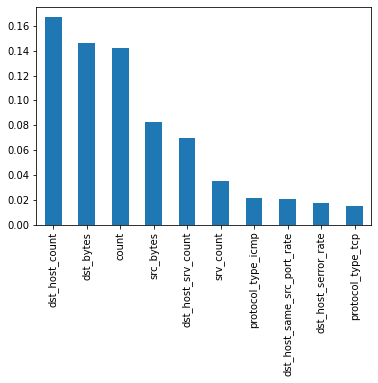

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, Y_train)
# display the relative importance of each attribute
#print(model.feature_importances_)

feat_importances1 = pd.Series(model.feature_importances_, index=cc)
feat_importances1.nlargest(10).plot(kind='bar')
plt.show()


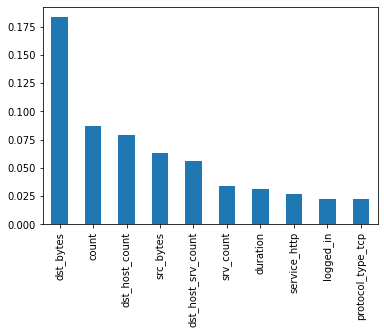

In [ ]:
model = ExtraTreesClassifier()
model.fit(X_test, Y_test)
# display the relative importance of each attribute
#print(model.feature_importances_)

feat_importances2 = pd.Series(model.feature_importances_, index=cc)
feat_importances2.nlargest(10).plot(kind='bar')
plt.show()

Comparing the features distinguishing the train and the test data

In [ ]:
X_combined = [X_train, X_test]
X_combined = np.concatenate(X_combined)
Y_combined = [np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])]
Y_combined = np.concatenate(Y_combined)


In [ ]:
model = ExtraTreesClassifier()
model.fit(X_combined, Y_combined)
# display the relative importance of each attribute
#print(model.feature_importances_)

There is no one single feature that drastically distinguishes between the train and the test set. The top 10 features highest = 6.19% and least = 3.87%. Thus droping features is not going to help here. 

Comparing the top 10 features, they contribute 75% for finding attacks in the train set and 61.73% in the test set. 

In [ ]:
imp = pd.concat([pd.DataFrame(cc),pd.DataFrame(model.feature_importances_)], axis=1)
imp.columns = ['features', 'importance']
imp = imp.sort_values(by=['importance'], ascending=False)
top = imp.head(10)

plt.bar(top['features'], top['importance'])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
imp[0:10]

In [ ]:
train_feat = 0
test_feat = 0

for x in top['features']:
  train_feat += feat_importances1[x]
  test_feat += feat_importances2[x]

train_feat, test_feat

# Reweighting 

In [ ]:
all_merged = [X_train, X_test]
all_merged = np.concatenate(all_merged)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(all_merged)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

[0.50695696 0.20664886] 0.7136058218026725


In [ ]:
X_train_red = pca.transform(X_train)
X_test_red = pca.transform(X_test)

X_train_attack_red = pca.transform(X_train_attack)
X_test_attack_red = pca.transform(X_test_attack)

X_train_no_red = pca.transform(X_train_no)
X_test_no_red = pca.transform(X_test_no)

In [ ]:
# analysing model performance without any reweighting

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score

clf = RFC(n_estimators=50, max_depth=20)

clf.fit(X_train_red, Y_train)
y_train_pred = clf.predict(X_train_red)
print(accuracy_score(Y_train, y_train_pred))

y_test_pred = clf.predict(X_test_red)
print(accuracy_score(Y_test, y_test_pred))

0.997832868948108
0.7794091554293825


In [ ]:
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score as AUC

def get_weights(X1, X2):

  X_classify = [X1, X2]
  X_classify = np.concatenate(X_classify)

  Y_classify = [np.ones(X1.shape[0]), np.zeros(X2.shape[0])]
  Y_classify = np.concatenate(Y_classify)

  clf = RFC(max_depth=20)

  predictions = np.zeros(Y_classify.shape)
  skf = SKF(n_splits=10, shuffle=True, random_state=0)
  for fold, (train_idx, test_idx) in enumerate(skf.split(X_classify, Y_classify)):
      print(fold)
      x_train, x_test = X_classify[train_idx], X_classify[test_idx]
      y_train, y_test = Y_classify[train_idx], Y_classify[test_idx]

      #print(x_train.shape, y_train.shape)  
      clf.fit(x_train, y_train)
      probs = clf.predict_proba(x_test)[:, 1]
      predictions[test_idx] = probs

  return predictions

In [ ]:
weights = get_weights(X_train_attack_red, X_test_attack_red)

In [ ]:
weights2 = get_weights(X_train_no_red, X_test_no_red)

In [ ]:
import pickle

open_file = open("weights.pkl", "wb")
pickle.dump(weights, open_file)
open_file.close()

open_file = open("weights2.pkl", "wb")
pickle.dump(weights2, open_file)
open_file.close()

In [ ]:
p1 = weights[0:X_train_attack_red.shape[0]] + 1e-3
w1 = (1./p1) - 1. 
w1 /= np.mean(w1) 

p2 = weights2[0:X_train_no_red.shape[0]] + 1e-3
w2 = (1./p2) - 1. 
w2 /= np.mean(w2) 

fw = [w1, w2]
fw = np.concatenate(fw)
#fw /= np.mean(fw)

In [ ]:
fw.shape

(125973,)

In [ ]:
pp = 0.1 + fw/10
pp = pp.astype('float32')


In [ ]:
X_train_attack_red.shape, w1.shape

((58630, 2), (58630,))

In [ ]:
!pip3 install --upgrade matplotlib

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 432x288 with 0 Axes>

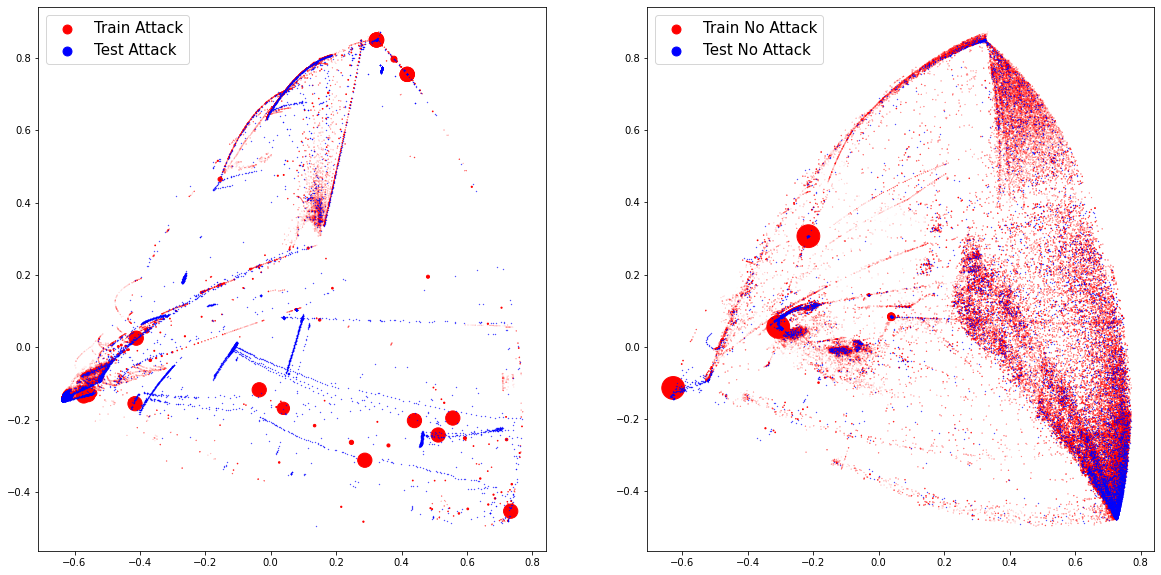

In [ ]:
from matplotlib.pyplot import figure

f = plt.figure()    
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))

# ax1.xlim(-1,1.5)
# ax1.ylim(-1,1)
ax1.scatter(X_train_attack_red[:,0],X_train_attack_red[:,1], c='r', s=w1/10, label='Train Attack')
ax1.scatter(X_test_attack_red[:,0],X_test_attack_red[:,1], c='b', s= 0.1, label='Test Attack')
legend = ax1.legend(frameon=True, fontsize=15)
for legobj in legend.legendHandles:
    legobj.set_sizes([80])


# ax2.xlim(-1,1.5)
# ax2.ylim(-1,1)
ax2.scatter(X_train_no_red[:,0],X_train_no_red[:,1], c='r', s=w2/10, label='Train No Attack')
ax2.scatter(X_test_no_red[:,0],X_test_no_red[:,1], c='b', s=0.1, label='Test No Attack')
legend = ax2.legend(frameon=True, fontsize=15)
for legobj in legend.legendHandles:
    legobj.set_sizes([80])


plt.show()

In [ ]:
clf = RFC(n_estimators=100, max_depth=8)

X_n = [X_train_attack_red, X_train_no_red]
X_n = np.concatenate(X_n)
Y_n = [np.ones(X_train_attack_red.shape[0]), np.zeros(X_train_no_red.shape[0])]
Y_n = np.concatenate(Y_n)

clf.fit(X_n, Y_n, sample_weight=pp)
y_train_pred = clf.predict(X_n)
print(accuracy_score(Y_n, y_train_pred))

y_test_pred = clf.predict(X_test_red)
Y_test = np.array(Y_test).astype('int32')
print(accuracy_score(Y_test, y_test_pred))

In [ ]:
y_train_attack_pred = []
y_train_no_pred = []

y_test_attack_pred = []
y_test_no_pred = []

for i in range(0,len(Y_test)):
  if(Y_test[i]==1):
    y_test_attack_pred.append(y_test_pred[i])
  else:
    y_test_no_pred.append(y_test_pred[i])

for i in range(0,len(Y_n)):
  if(Y_n[i]==1):
    y_train_attack_pred.append(y_train_pred[i])
  else:
    y_train_no_pred.append(y_train_pred[i])

In [ ]:
y_train_attack_pred = np.array(y_train_attack_pred).astype('int32')
y_train_no_pred = np.array(y_train_no_pred).astype('int32')

y_test_attack_pred = np.array(y_test_attack_pred).astype('int32')
y_test_no_pred = np.array(y_test_no_pred).astype('int32')

print(accuracy_score(np.ones(y_train_attack_pred.shape[0]), y_train_attack_pred), accuracy_score(np.zeros(y_train_no_pred.shape[0]), y_train_no_pred))
print(accuracy_score(np.ones(y_test_attack_pred.shape[0]), y_test_attack_pred), accuracy_score(np.zeros(y_test_no_pred.shape[0]), y_test_no_pred))

The train set accuracy falls by 1.63% but the test set accuarcy increases by from 76.40% to 78.93% which is a 2.53% increase. Although the accuarcy increases the net accuracy is still lesser than 80% which is  not ideal for the performance. The lack in the performance of this technique can be attributed to the fact that the the overlap between the attack datapoints is not high, so there are very new attacks that doesn't just deviate from the previous patterns but has completely new patterns. 

98.36 ---> 96.73  (-1.63)
76.40 ---> 78.93  (+2.53)

NOTE: Here for sampling the whole test dataset is taken not a part of it, despite that the returns are poor.

Therefore there is a need to retrain the model of sample once again to increase the accuracy to learn online. 

# Creating batches

In [ ]:
'''
Preparing the batches for testing online(continual) learning algorithms

X0: Normal Data points
X1: Type 1 attacks (Only DOS)
X2: Type 2 attacks (Other than DOS - Probe, U2R, R2L)

batches wll alternate between B1:(X0, X1) and B2:(X0, X2)
X0: 50-60% in each batch and remaining is the corresponding attack type

Batches: 5*B1, 5*B2, 5*B1, 5*B2

'''

X0 = []
X1 = []
X2 = []
X3 = []

for i in range(len(Y_train)):
  if(Y_train[i]==0):
    X0.append(X_train[i])
  elif (Y_train[i]==1):
    X1.append(X_train[i])
  elif (Y_train[i]==2):
    X2.append(X_train[i])
  elif (Y_train[i]==3):
    X3.append(X_train[i])


for i in range(len(Y_test)):
  if(Y_test[i]==0):
    X0.append(X_test[i])
  elif (Y_test[i]==1):
    X1.append(X_test[i])
  elif (Y_test[i]==2):
    X2.append(X_test[i])
  elif (Y_test[i]==3):
    X3.append(X_test[i])

X0 = np.array(X0).astype('float')
X1 = np.array(X1).astype('float')
X2 = np.array(X2).astype('float')
X3 = np.array(X3).astype('float')

from sklearn.utils import shuffle
X0 = shuffle(X0)
X1 = shuffle(X1)
X2 = shuffle(X2)
X3 = shuffle(X3)

X = [X0, X1, X2, X3]

In [ ]:
# creating the required batches

nb = 30   # Total number of batches
bs = 5000 # Batch size
t = 5     # numer of times a batch type is repeated continuously
f = X0.shape[1] # bumber of features in the data
batches = []
btype = 1
t0 = []
t1 = []
t2 = []
# second method 4 batches only

# for i in range(0,len(X)-1,2):
#   x = 0.50 + 0.2 * np.random.random()
#   y = int(bs * x)

#   bx, by = [], []
#   print(y/bs)
#   by = np.concatenate([i * np.ones(y), (i+1) * np.ones(bs-y)])
#   bx[0:y] = X[i][np.random.choice(X[i].shape[0], size=y, replace= True)]
#   bx[y:bs] = X[i+1][np.random.choice(X[i+1].shape[0], size=bs-y, replace= True)]

#   print(np.shape(bx), np.shape(by))
#   batches.append([bx,by])

for i in range(nb):
  
  bx = np.zeros((bs, f))
  by = []

  if(i % t == 0 and i!=0):
    btype = btype ^ 1

  if(btype==1):
    x = 0.40 + 0.2 * np.random.random()
    y = int(bs * x)
    t0.append(y)
    t1.append(bs-y)
    t2.append(0)

    print(y/bs)
    by = np.concatenate([np.zeros(y), np.ones(bs-y)])
    bx[0:y, :] = X0[np.random.choice(X0.shape[0], size=y, replace= False),:]
    bx[y:bs, :] = X1[np.random.choice(X1.shape[0], size=bs-y, replace= False),:]

    batches.append([bx,by])
  
  else:
    x = 0.40 + 0.2 * np.random.random()
    y = int(bs * x)
    t0.append(y)
    t1.append(0)
    t2.append(bs-y)

    print(y/bs)
    by = np.concatenate([np.zeros(y), 2 * np.ones(bs-y)])
    bx[0:y, :] = X0[np.random.choice(X0.shape[0], size=y, replace= False),:]
    bx[y:bs, :] = X2[np.random.choice(X2.shape[0], size=bs-y, replace= False),:]

    batches.append([bx,by])   


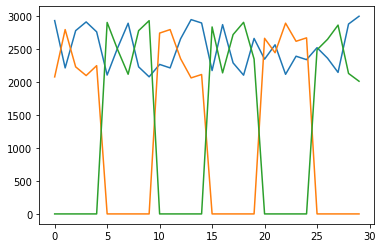

In [ ]:
p = np.arange(len(t0))
plt.plot(p, t0)
plt.plot(p, t1)
plt.plot(p, t2)
plt.show()

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfacc1 = []

ep = 50 # number of epochs for each batch

for i in range(nb-1):
  bx, by = batches[i][0], batches[i][1]
  bx, by = shuffle(bx, by)

  clf = RandomForestClassifier(n_estimators = 50)
  clf.fit(bx, by)
  if(i==0):
    rfacc1.append(accuracy_score(by, clf.predict(bx)))
  rfacc1.append(accuracy_score(batches[i+1][1], clf.predict(batches[i+1][0])))

  if(i+1==nb-1):
    rfacc1.append(accuracy_score(batches[i+1][1], clf.predict(batches[i+1][0])))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, warm_start=True)

rfacc = []

ep = 50 # number of epochs for each batch

# XX = batches[:,0]
# YY = batches[:,1]

# for i in range(0,nb):
#   #clf.fit(XX[i%iter].astype('float32'), YY[i%iter].astype('int32'))

#   if(i==0):
#     clf.fit(XX[i], YY[i])
#     #clf.partial_fit(XX[i%iter], YY[i%iter], classes=[0,1])
#   xe = clf.predict(XX[(i+1)])
#   t = accuracy_score(YY[(i+1)].astype('int32'), xe)
#   print(t)

#   if(t<0.95):
#     print("Updatng...")
#     clf.n_estimators += 30
#     clf.fit(XX[(i+1)], YY[(i+1)])


for i in range(nb-1):
  bx, by = batches[i][0], batches[i][1]
  bx, by = shuffle(bx, by)

  if(i==0):
    clf.fit(bx, by)

  cacc = accuracy_score(batches[i+1][1], clf.predict(batches[i+1][0]))
  print(cacc)

  if(cacc < 0.90):
    print('Adding more trees')
    clf.n_estimators += 100
    clf.fit(bx, by)

  if(i==0):
    rfacc.append(accuracy_score(by, clf.predict(bx)))
  rfacc.append(accuracy_score(batches[i+1][1], clf.predict(batches[i+1][0])))

  if(i+1==nb-1):
    rfacc.append(accuracy_score(batches[i+1][1], clf.predict(batches[i+1][0])))

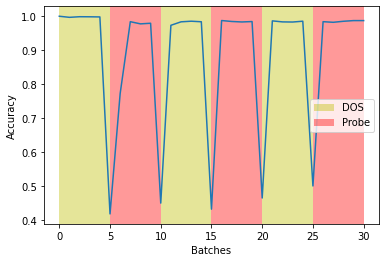

0.8937225806451612

In [ ]:
plt.plot(np.arange(len(rfacc)), rfacc)
#plt.plot(np.arange(len(rfacc1)), rfacc1)
l = 1
k = 0.4

plt.axvspan(0,5*l, facecolor='y', alpha=k, label='DOS')
plt.axvspan(5*l,10*l, facecolor='r', alpha=k, label='Probe')
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.show()
np.mean(rfacc)

# Finetuning with test dataset stream


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# building the tf model 
# init1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# init2 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0, seed=None)

input = Input(shape=[122], name='input')
d1 = Dense(120, activation='relu', name='dense1')(input)
dr1 = Dropout(0.2, name='dropout1')(d1)
d2 = Dense(80, activation='relu',  name='dense2')(dr1)
dr2 = Dropout(0.2, name='dropout2')(d2)
d3  = Dense(40, activation='relu', name='dense3')(dr2)
dr3 = Dropout(0.2, name='dropout3')(d3)
d4  = Dense(20, activation='relu', name='dense4')(dr3)
output = Dense(3, activation='relu', name='output')(d4)
output_proba = tf.nn.softmax(output)

model = tf.keras.Model(inputs = input, outputs = output_proba)
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 122)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 120)               14760     
_________________________________________________________________
dropout1 (Dropout)           (None, 120)               0         
_________________________________________________________________
dense2 (Dense)               (None, 80)                9680      
_________________________________________________________________
dropout2 (Dropout)           (None, 80)                0         
_________________________________________________________________
dense3 (Dense)               (None, 40)                3240      
_________________________________________________________________
dropout3 (Dropout)           (None, 40)                0  

In [ ]:
finetune_accuracy = []

ep = 50 # number of epochs for each batch

for i in range(nb):
  bx, by = batches[i][0], batches[i][1]
  bx, by = shuffle(bx, by)

  bx = np.array(bx).astype('float')
  by = np.array(by).astype('float')

  for j in range(ep):
    for k in range(0,len(bx)-batch_size, batch_size):
      model.train_on_batch(bx[k:k+batch_size], by[k:k+batch_size])
    if(j%10==0):
      finetune_accuracy.append(model.evaluate(bx, by)[1])

157/157 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9954


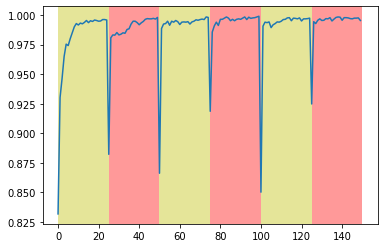

0.9885646653175354

In [ ]:
l = 5
k = 0.4

plt.plot(np.arange(len(finetune_accuracy)), finetune_accuracy)
plt.axvspan(0,5*l, facecolor='y', alpha=k)
plt.axvspan(5*l,10*l, facecolor='r', alpha=k)
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
plt.show()

np.mean(finetune_accuracy)

In [ ]:
import pickle

open_file = open("finetune_accuracy1.pkl", "wb")
pickle.dump(finetune_accuracy, open_file)
open_file.close()

# Rehersal Based Strategies


## Experience Replay Buffer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# building the tf model 
# init1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# init2 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0, seed=None)

input = Input(shape=[122], name='input')
d1 = Dense(120, activation='relu', name='dense1')(input)
dr1 = Dropout(0.2, name='dropout1')(d1)
d2 = Dense(80, activation='relu',  name='dense2')(dr1)
dr2 = Dropout(0.2, name='dropout2')(d2)
d3  = Dense(40, activation='relu', name='dense3')(dr2)
dr3 = Dropout(0.2, name='dropout3')(d3)
d4  = Dense(20, activation='relu', name='dense4')(dr3)
output = Dense(3, activation='relu', name='output')(d4)
output_proba = tf.nn.softmax(output)

model = tf.keras.Model(inputs = input, outputs = output_proba)
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 122)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 120)               14760     
_________________________________________________________________
dropout1 (Dropout)           (None, 120)               0         
_________________________________________________________________
dense2 (Dense)               (None, 80)                9680      
_________________________________________________________________
dropout2 (Dropout)           (None, 80)                0         
_________________________________________________________________
dense3 (Dense)               (None, 40)                3240      
_________________________________________________________________
dropout3 (Dropout)           (None, 40)                0  

In [ ]:
def update_buffer(buffer, batch):

  current_size = len(buffer[0])

  if(current_size == 0):
    
    buffer = batch
  
  elif((current_size > 0) and ((current_size + len(batch[0])) <= buffer_size)):

    bx = list(batch[0])
    by = list(batch[1])

    buffer[0] = np.concatenate([buffer[0], bx])
    buffer[1] = np.concatenate([buffer[1], by])

  else:
    
    combinedx = np.concatenate([buffer[0], batch[0]])
    combinedy = np.concatenate([buffer[1], batch[1]])

    combinedx, combinedy = shuffle(combinedx, combinedy)

    c_size = combinedx.shape[0]

    choice = np.random.choice(c_size, size=buffer_size)

    buffer[0] = combinedx[choice]
    buffer[1] = combinedy[choice]

  return buffer

def get_data(buffer, bs):

  current_size = len(buffer[0])
  #print("Current buffer size: {}".format(current_size))

  if(current_size == 0):
    b_data = [[],[]]

  elif(current_size <= bs):
    b_data = buffer
  
  else:

    choice = np.random.choice(len(buffer[0]), size=bs)

    b_data = [[],[]]
    b_data[0] = buffer[0][choice]
    b_data[1] = buffer[1][choice]

  print("Buffer size sent : {}".format(len(b_data[0])))
  return b_data


In [ ]:
er_accuracy = []
buffer = [[],[]]
buffer_size = 10000
batch_buffer_size = 5000
ep = 50 # number of epochs for each batch
batch_size = 1000

cx, cy = [],[]
for i in range(nb):
  print("--------------------------------------------")
  print("Batch number {}".format(i))
  bx, by = batches[i][0], batches[i][1]
  bx, by = shuffle(bx, by)

  buffer_data = get_data(buffer, batch_buffer_size)

  #print(buffer_data)

  if len(buffer_data[0]) > 0:
    bx = np.concatenate([bx, buffer_data[0]])
    by = np.concatenate([by, buffer_data[1]])

  if(len(cx)==0):
    cx = bx
    cy = by
  else:
    cx = np.concatenate([cx, bx])
    cy = np.concatenate([cy, by])

  print("Size of buffer in this batch {}".format(bx.shape[0]))
  for j in range(ep):
    for k in range(0, len(bx)-batch_size, batch_size):
      model.train_on_batch(bx[k:k+batch_size], by[k:k+batch_size])
    if(j%10==0):
      er_accuracy.append(model.evaluate(bx, by)[1])
  
  buffer = update_buffer(buffer, batches[i])

--------------------------------------------
Batch number 0
Buffer size sent : 0
Size of buffer in this batch 10000
313/313 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9401
--------------------------------------------
Batch number 1
Buffer size sent : 5000
Size of buffer in this batch 10000
313/313 [==============================] - 0s 1ms/step - loss: 0.0659 - accuracy: 0.9814
--------------------------------------------
Batch number 2
Buffer size sent : 5000
Size of buffer in this batch 10000
313/313 [==============================] - 0s 1ms/step - loss: 0.0395 - accuracy: 0.9891
--------------------------------------------
Batch number 3
Buffer size sent : 5000
Size of buffer in this batch 10000
313/313 [==============================] - 0s 1ms/step - loss: 0.0271 - accuracy: 0.9918
--------------------------------------------
Batch number 4
Buffer size sent : 5000
Size of buffer in this batch 10000
313/313 [==============================] - 0s 1ms/st

In [ ]:
open_file = open("finetune_accuracy1.pkl","rb")
gg = pickle.load(open_file)
open_file.close()

In [ ]:
open_file = open("er_accuracy_final.pkl","rb")
hh = pickle.load(open_file)
open_file.close()


In [ ]:
open_file = open("der_accuracy.pkl","rb")
ff = pickle.load(open_file)
open_file.close()

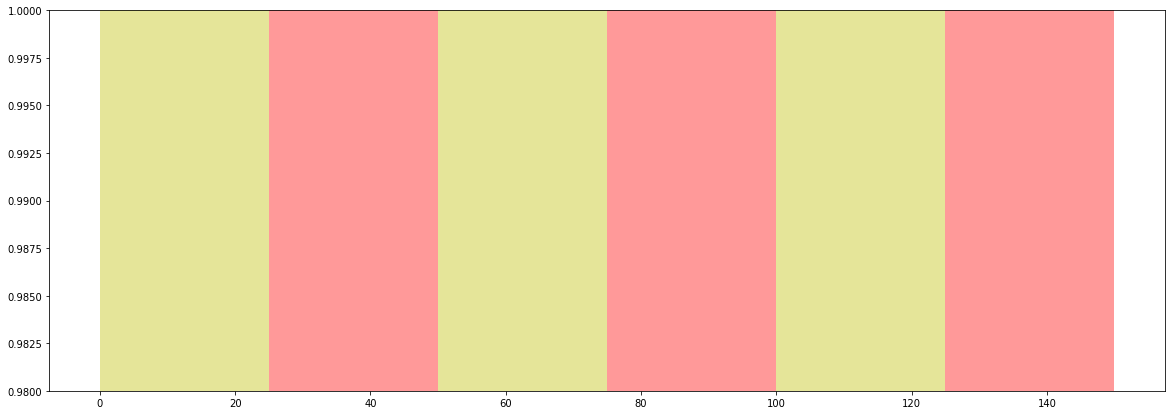

In [ ]:
l = 5
k = 0.4
plt.figure(figsize=(20,7))
plt.ylim(0.98,1)
ff = er_accuracy
plt.plot(np.arange(len(ff)), ff, c='r')
# plt.plot(np.arange(len(hh)), hh, c='b')
# plt.plot(np.arange(len(gg)), gg, c='g')
#plt.plot(np.arange(len(finetune_accuracy)), finetune_accuracy, c='g')
plt.axvspan(0,5*l, facecolor='y', alpha=k)
plt.axvspan(5*l,10*l, facecolor='r', alpha=k)
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
plt.show()

#np.mean(er_accuracy), np.mean(ff), np.mean(gg)

In [ ]:
import pickle
er_accuracy = []
open_file = open("er_accuracy.pkl", "wb")
pickle.dump(er_accuracy, open_file)
open_file.close()

In [ ]:
er_accuracy

[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Dark Experience Replay

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# building the tf model 
# init1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# init2 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0, seed=None)

def create_model():
  input = Input(shape=[122], name='input')
  d1 = Dense(120, activation='relu', name='dense1')(input)
  dr1 = Dropout(0.2, name='dropout1')(d1)
  d2 = Dense(80, activation='relu',  name='dense2')(dr1)
  dr2 = Dropout(0.2, name='dropout2')(d2)
  d3  = Dense(40, activation='relu', name='dense3')(dr2)
  dr3 = Dropout(0.2, name='dropout3')(d3)
  d4  = Dense(20, activation='relu', name='dense4')(dr3)
  output = Dense(3, activation='relu', name='output')(d4)
  output_proba = tf.nn.softmax(output)

  model = tf.keras.Model(inputs = input, outputs = output_proba)

  return model
# model.summary()

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
def update_buffer(buffer, batch):

  current_size = len(buffer[0])

  if(current_size == 0):
    
    buffer = batch
  
  elif((current_size > 0) and ((current_size + len(batch[0])) <= buffer_size)):

    bx = list(batch[0])
    by = list(batch[1])

    buffer[0] = np.concatenate([buffer[0], bx])
    buffer[1] = np.concatenate([buffer[1], by])

  else:
    
    combinedx = np.concatenate([buffer[0], batch[0]])
    combinedy = np.concatenate([buffer[1], batch[1]])

    combinedx, combinedy = shuffle(combinedx, combinedy)

    c_size = combinedx.shape[0]

    choice = np.random.choice(c_size, size=buffer_size)

    buffer[0] = combinedx[choice]
    buffer[1] = combinedy[choice]

  return buffer

def get_data(buffer, bs):

  current_size = len(buffer[0])
  print("Current buffer size: {}".format(current_size))

  if(current_size == 0):
    b_data = [[],[]]

  elif(current_size <= bs):
    b_data = buffer
  
  else:

    choice = np.random.choice(len(buffer[0]), size=bs)

    b_data = [[],[]]
    b_data[0] = buffer[0][choice]
    b_data[1] = buffer[1][choice]

  print("Buffer size sent : {}".format(len(b_data[0])))
  return b_data


In [ ]:
loss_object1 = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object2 = tf.keras.losses.MeanSquaredError()

def grad(model, batch, buffer, buffer1, alpha):
  #print("Computing the gradients...")
  with tf.GradientTape() as tape:

    loss_1 = 0.0
    loss_2 = 0.0
    loss_3 = 0.0

    #print("Loss 1:")
    tape.watch(model.trainable_variables)

    #print(batch[0].shape)
    loss_1 = loss_object1(batch[1], model(batch[0]))

    #print("Loss 2: ")
    #print(np.shape(buffer[1]), np.shape(buffer[0]))
    if(len(buffer[1]) > 0):
      loss_2 = loss_object2(buffer[1], model(buffer[0]))
    else:
      loss_2 = 0.0
    
    #print(np.shape(buffer1[1]), np.shape(buffer1[0]))
    if(len(buffer1[1]) > 0):
      loss_3 = loss_object1(buffer1[1], model(buffer1[0]))
    else:
      loss_3 = 0.0

    #print(loss_1, loss_2)
    loss_value = 1.0 * loss_1 + alpha * loss_2 #+ 0.0 * loss_3


  #print("Inside gradients")
  return loss_value, [loss_1, loss_2], tape.gradient(loss_value, model.trainable_variables)


In [ ]:
# dark experience replay

model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

der_accuracy = []
buffer = [[],[]]
buffer1 = [[],[]]
buffer_size = 10000
batch_buffer_size = 5000
alpha = 0.5 # Regularization parameter for storing old knowledge
ep = 50 # number of epochs for each batch
train_batch_size = 512

for i in range(nb):

  # if(i<5):
  #   alpha = 0.0
  # else:
  #   alpha = 0.5

  print("--------------------------------------------")
  print("Batch number {}".format(i))
  bx, by = batches[i][0], batches[i][1]
  bx, by = shuffle(bx, by)

  buffer_data = get_data(buffer, batch_buffer_size)
  #buffer_data1 = get_data(buffer1, batch_buffer_size)

  print("Size of buffer in this batch {}".format(bx.shape[0]))

  if len(buffer_data[0]) > 0:
    bx = np.concatenate([bx, buffer_data[0]])
    by = np.concatenate([by, buffer_data[1]])
  
  bx, by = shuffle(bx, by)
  for j in range(ep):
    
    for k in range(0,len(bx)-train_batch_size,train_batch_size):
      #print(k)
      #loss_value, grads = grad(model, batches[i], buffer_data)
      x = []
      y = []

      x1 = []
      y1 = []

      x2 = []
      y2 = []

      x = bx[k:k+train_batch_size]
      x = np.reshape(x, (train_batch_size, 122))
      y = by[k:k+train_batch_size]

      # if(len(buffer_data[0]) > 0):
      #   x1 = buffer_data[0][k:k+train_batch_size]
      #   #print(np.shape(buffer_data[0]), np.shape(x1))
      #   x1 = np.reshape(x1, (train_batch_size, 122))
      #   y1 = buffer_data[1][k:k+train_batch_size]

      # if(len(buffer_data1[0]) > 0):
      #   x2 = buffer_data1[0][k:k+train_batch_size]
      #   x2 = np.reshape(x2, (train_batch_size, 122))
      #   y2 = buffer_data1[1][k:k+train_batch_size]
       
      # else:
      #   x = bx[k:]
      #   x = np.reshape(x, (len(bx)-k, 122))
      #   y = by[k:]
      #print(np.array(y2).shape)
      loss_value, ll, grads = grad(model, [x, y], [[],[]], [[],[]], alpha)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      #model.train_on_batch(bx, by)

    if(j%10==0):
      y_pred = np.argmax(model(bx), axis=1)
      acc = accuracy_score(by, y_pred)
      der_accuracy.append(acc)
      print("Accuracy = {}".format(acc * 100))
      print(ll[0], ll[1])
  
  logit_buffer = [[],[]]

  logit_buffer[0] = batches[i][0]
  logit_buffer[1] = model.predict(batches[i][0])
  buffer = update_buffer(buffer, logit_buffer)
  
  # logit_buffer1 = [[],[]]

  # logit_buffer1[0] = batches[i][0]
  # logit_buffer1[1] = batches[i][1]
  # buffer1 = update_buffer(buffer1, logit_buffer1)

In [ ]:
# open_file = open("er_accuracy.pkl", "rb")
# er_accuracy = pickle.load(open_file)
# open_file.close()

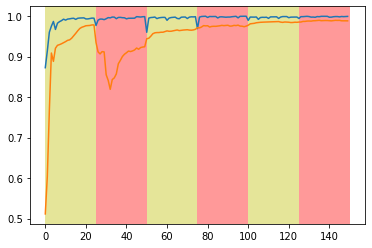

(0.9523362584908803, 0.9936200000000001)

In [ ]:
# Experience replay buffer

l = 5
k = 0.4

#plt.plot(np.arange(len(f1)), f1)
plt.plot(np.arange(len(der_accuracy)), der_accuracy)
plt.plot(np.arange(len(er_accuracy)), er_accuracy)
#plt.plot(np.arange(len(f)), f)
#plt.ylim(0.5,1)
plt.axvspan(0,5*l, facecolor='y', alpha=k)
plt.axvspan(5*l,10*l, facecolor='r', alpha=k)
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
# plt.axvspan(30*l,35*l, facecolor='y', alpha=k)
# plt.axvspan(35*l,40*l, facecolor='r', alpha=k)
# plt.axvspan(40*l,45*l, facecolor='y', alpha=k)
# plt.axvspan(45*l,50*l, facecolor='r', alpha=k)
plt.show()

np.mean(er_accuracy), np.mean(der_accuracy)

In [ ]:
import pickle

open_file = open("der_accuracy.pkl", "rb")
ff = pickle.load(open_file)
open_file.close()

## Exstream (RAM not enough)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

# building the tf model 
# init1 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# init2 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0, seed=None)

def create_model():
  input = Input(shape=[122], name='input')
  d1 = Dense(120, activation='relu', name='dense1')(input)
  dr1 = Dropout(0.2, name='dropout1')(d1)
  d2 = Dense(80, activation='relu',  name='dense2')(dr1)
  dr2 = Dropout(0.2, name='dropout2')(d2)
  d3  = Dense(40, activation='relu', name='dense3')(dr2)
  dr3 = Dropout(0.2, name='dropout3')(d3)
  d4  = Dense(20, activation='relu', name='dense4')(dr3)
  output = Dense(3, activation='relu', name='output')(d4)
  output_proba = tf.nn.softmax(output)

  model = tf.keras.Model(inputs = input, outputs = output_proba)

  return model
# model.summary()

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
from sklearn.metrics import mean_squared_error
def find_points(batches, le):
  buffer= batches[0]
  y = batches[1]

  counts = Counter(y)
  cmax = max(counts, key= lambda x: counts[x]) # class with the maximum number of points 

  Xc = []
  Xi = [] 

  #print(cmax)

  for i in range(len(buffer)):
    if(y[i]==cmax):
      Xc.append(buffer[i])
      Xi.append(i)

  tsize = len(Xc) # total number of occurances of class cmax

  #print(np.shape(Xc))
  least_diff = 100000000.0
  m1, m2 = 0,0
  for i in range(tsize):
    for j in range(i+1, tsize):
      #print(i,j)
      err = mean_squared_error(Xc[i], Xc[j])

      if(err < least_diff):
        least_diff = err
        m1 = Xi[i]
        m2 = Xi[j]

  #print(m1, m2, cmax)
  return m1, m2, cmax

In [ ]:
np.shape(np.random.randint(100, size = (5000,122)))

(5000, 122)

In [ ]:
torch.cuda.current_device()

0

In [ ]:
import torch
import numpy as np
H = torch.Tensor(np.random.randint(100, size=(5000,122)))
id = 0
with torch.no_grad():
  M, d = H.shape
  H2 = torch.reshape(H, (M, 1, d))  # reshaping for broadcasting
  inside = H2 - H
  square_sub = torch.mul(inside, inside)  # square all elements
  psi = torch.sum(square_sub, dim=2)  # capacity x batch_size

  # infinity on diagonal
  mb = psi.shape[0]
  print(mb)
  diag_vec = torch.ones(mb).cuda(id) * np.inf
  mask = torch.diag(torch.ones_like(diag_vec).cuda(id))
  psi = mask * torch.diag(diag_vec) + (1. - mask) * psi

  # grab indices
  idx = torch.argmin(psi)
  idx_row = idx / mb
  idx_col = idx % mb
  print(idx_row, idx_col)
# d1 = batches[0][0][0:1000]
# print(np.shape(d1))
# a, b = d1.shape
# d2 = np.reshape(d1,(a,1,b))
# print(np.shape(d2))
# d3 = d2-d1
# print(np.shape(d3))

# d4 = np.multiply(d3, d3)
# print(np.shape(d4) )

In [ ]:
def update_buffer(buffer, batch, le):

  csize = len(buffer[0])  # current size of the buffer
  bsize = len(batch[0])   # size of the batch received to be updated

  print(csize, bsize)
  if (csize == 0):
    buffer[0] = batch[0]
    buffer[1] = batch[1]
    buffer[2] = np.ones(bsize)


  elif (buffer_size >= (csize + bsize)):
    
    bx = list(batch[0])
    by = list(batch[1])
    bw = np.ones(bsize)

    buffer[0] = np.concatenate([buffer[0], bx])
    buffer[1] = np.concatenate([buffer[1], by])
    buffer[2] = np.concatenate([buffer[2], bw])

  else:
    
    for i in range(bsize):

      r1, r2, y = find_points(buffer, le) # points to be replaced in the buffer, the ones closest in the class with the maximum points

      c1 = buffer[2][r1]
      c2 = buffer[2][r2]

      p1 = buffer[0][r1]
      p2 = buffer[0][r2]

      c3 = c1+c2
      p3 = (c1 * p1 + c2 * p2)/(c1+c2)
      y3 = y

      c4 = 1
      p4 = batch[i][0]
      y4 = batch[i][1]

      buffer[0][r1] = p3
      buffer[1][r1] = y3
      buffer[2][r1] = c3

      buffer[0][r2] = p4
      buffer[1][r2] = y4
      buffer[2][r2] = c4

      le[0] = r1
      le[1] = r2

  return buffer

In [ ]:
loss_object1 = tf.keras.losses.SparseCategoricalCrossentropy()

def grad(model, batch):
  #print("Computing the gradients...")
  with tf.GradientTape() as tape:

    #print("Loss 1:")
    tape.watch(model.trainable_variables)

    #print(batch[0].shape)
    loss_value = loss_object1(batch[1], model(batch[0]))

  #print("Inside gradients")
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


In [ ]:
# exstream

model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

exs_accuracy = []
buffer = [[],[],[]]  # X, y, weights
buffer_size = 10000
alpha = 0.5         # Regularization parameter for storing old knowledge
ep = 50             # number of epochs for each batch
train_batch_size = 512
le = np.zeros(2)             # last edited data points to avoid recomputing

for i in range(nb):

  print("--------------------------------------------")
  print("Batch number {}".format(i))

  buffer = update_buffer(buffer, batches[i], le)

  bx, by = buffer[0], buffer[1]
  bx, by = shuffle(bx, by)

  for j in range(ep):
    for k in range(0,len(bx)-train_batch_size,train_batch_size):
      #print(k)
      #loss_value, grads = grad(model, batches[i], buffer_data)
      x = []
      y = []

      x = bx[k:k+train_batch_size]
      x = np.reshape(x, (train_batch_size, 122))
      y = by[k:k+train_batch_size]

      loss_value, grads = grad(model, [x, y])
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      #model.train_on_batch(bx, by)

    if(j%10==0):
      y_pred = np.argmax(model(batches[i][0]), axis=1)
      acc = accuracy_score(batches[i][1], y_pred)
      exs_accuracy.append(acc)
      print("Accuracy = {}".format(acc * 100))
  

In [ ]:
# open_file = open("er_accuracy.pkl", "rb")
# er_accuracy = pickle.load(open_file)
# open_file.close()

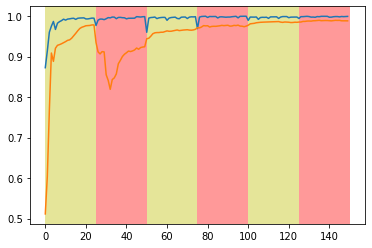

(0.9523362584908803, 0.9936200000000001)

In [ ]:
# Experience replay buffer

l = 5
k = 0.4

#plt.plot(np.arange(len(f1)), f1)
plt.plot(np.arange(len(der_accuracy)), der_accuracy)
plt.plot(np.arange(len(er_accuracy)), er_accuracy)
#plt.plot(np.arange(len(f)), f)
#plt.ylim(0.5,1)
plt.axvspan(0,5*l, facecolor='y', alpha=k)
plt.axvspan(5*l,10*l, facecolor='r', alpha=k)
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
# plt.axvspan(30*l,35*l, facecolor='y', alpha=k)
# plt.axvspan(35*l,40*l, facecolor='r', alpha=k)
# plt.axvspan(40*l,45*l, facecolor='y', alpha=k)
# plt.axvspan(45*l,50*l, facecolor='r', alpha=k)
plt.show()

np.mean(er_accuracy), np.mean(der_accuracy)

In [ ]:
import pickle

open_file = open("der_accuracy.pkl", "rb")
ff = pickle.load(open_file)
open_file.close()

# LWF (torch)

In [ ]:
import torch
torch.backends.cudnn.benchmark=True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import copy

import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def kaiming_normal_init(m):
	if isinstance(m, nn.Conv2d):
		nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
	elif isinstance(m, nn.Linear):
		nn.init.kaiming_normal_(m.weight, nonlinearity='sigmoid')



def MultiClassCrossEntropy(logits, labels, T):
	# Ld = -1/N * sum(N) sum(C) softmax(label) * log(softmax(logit))
	labels = Variable(labels.data, requires_grad=False).to(device)
	outputs = torch.log_softmax(logits/T, dim=1)   # compute the log of softmax values
	labels = torch.softmax(labels/T, dim=1)
	# print('outputs: ', outputs)
	# print('labels: ', labels.shape)
	outputs = torch.sum(outputs * labels, dim=1, keepdim=False)
	outputs = -torch.mean(outputs, dim=0, keepdim=False)
	# print('OUT: ', outputs)
	return Variable(outputs.data, requires_grad=True).to(device)
 
class Model(nn.Module):
  def __init__(self, classes):
    # Hyper Parameters
    self.init_lr = 0.00005
    self.num_epochs = 100
    self.batch_size = 512
    self.lower_rate_epoch = [int(0.7 * self.num_epochs), int(0.9 * self.num_epochs)] #hardcoded decay schedule
    self.lr_dec_factor = 5

    self.pretrained = False
    self.momentum = 0.9
    self.weight_decay = 0.0001
    # Constant to provide numerical stability while normalizing
    self.epsilon = 1e-16


    # Network architecture
    super(Model, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Linear(122, 200),
        nn.ReLU(),
        nn.Linear(200, 150),
        nn.ReLU(),
        nn.Linear(150, 80),
        nn.ReLU(),
        nn.Linear(80, 40) 
    )

    self.output = nn.Linear(40, classes)
    #self.model.apply(kaiming_normal_init)

  # n_classes is incremented before processing new data in an iteration
  # n_known is set to n_classes after all data for an iteration has been processed
    self.n_classes = 0
    self.n_known = 0


  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.output(x)
    return x

  def increment_classes(self, total_classes):

    print(self.output)
    prev_weights = self.output.weight.data
    self.output = nn.Linear(40, total_classes, bias=False)
    print(model)
    # self.fc = self.model.fc

    kaiming_normal_init(self.output.weight)
    print(prev_weights)
    self.output.weight.data[:2] = prev_weights
    # self.n_classes += n

  def classify(self, images):

    _, preds = torch.max(torch.softmax(self.forward(images), dim=1), dim=1, keepdim=False)

    return preds

  def update(self, batches, acc):

  # Save a copy to compute distillation outputs
    batch_size = 512

    optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr)

    #print(np.shape(dataset[0]), np.shape(dataset[1]))

    # from sklearn.preprocessing import OneHotEncoder
    # enc = OneHotEncoder()
    # dataset[1] = enc.fit_transform(np.reshape(dataset[1],(5000,1))).toarray()

    print("Initial learning... ")
    for b in batches[0:5]:
      dataset = b
      dataset[0], dataset[1] = shuffle(dataset[0], dataset[1])
      for epoch in range(self.num_epochs):
        for t in range(0,len(dataset[0])-batch_size,batch_size):
          bx = Variable(torch.FloatTensor(dataset[0][t:t+batch_size])).to(device)
          by = Variable(torch.LongTensor(dataset[1][t:t+batch_size])).to(device)

          #print(bx, by)
          optimizer.zero_grad()
          logits = self.forward(bx)
          loss = nn.CrossEntropyLoss()(logits, by)
          #print("Loss: {}".format(loss))
          loss.backward()
          optimizer.step()
        if(epoch%1==0):
          pred = torch.argmax(model(torch.FloatTensor(dataset[0])),axis=1).numpy()
          acc.append(accuracy_score(dataset[1], pred))
    #return acc


    prev_model = copy.deepcopy(self)
    prev_model.to(device)

    self.increment_classes(3)

    print("Distillation Loss...")
    tp = 59 # stop distillation after that 
    
    optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr/2)

    for k in range(len(batches[5:])):
      print(5+k)
      dataset = batches[5+k]
      dataset[0], dataset[1] = shuffle(dataset[0], dataset[1])

      if(k>2):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr/10)

      for epoch in range(self.num_epochs):
        for t in range(0,len(dataset[0])-batch_size,batch_size):
          bx = Variable(torch.FloatTensor(dataset[0][t:t+batch_size])).to(device)
          by = Variable(torch.LongTensor(dataset[1][t:t+batch_size])).to(device)

          #print(bx, by)
          optimizer.zero_grad()
          logits = self.forward(bx)
          cls_loss = nn.CrossEntropyLoss()(logits, by)
          #print("Loss: {}".format(loss))

          dist_target = prev_model.forward(bx)
          logits_dist = logits[:,:-2]
          dist_loss = MultiClassCrossEntropy(logits_dist, dist_target, 2)
     
          if(tp>0):
            loss = dist_loss + 100 * cls_loss
            loss.backward()
            optimizer.step()
          # else:
          #   loss = dist_loss
          #   loss.backward()
          #   optimizer.step()

        if(epoch % 1 ==0):
          pred = torch.argmax(model(torch.FloatTensor(dataset[0])),axis=1).numpy()
          acc.append(accuracy_score(dataset[1], pred))
        tp = tp - 1
    return acc

In [ ]:
model = Model(2)
acc = []
acc = model.update(batches, acc)

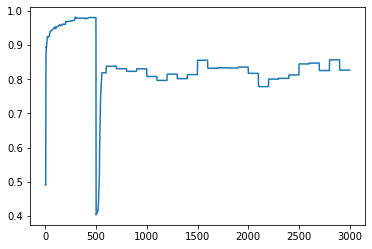

In [ ]:
acc = np.array(acc).astype('float32')
plt.plot(np.arange(len(acc)), acc)
plt.show()

# SHAP - Understandable AI

In [ ]:
Counter(Y_test)

Counter({0: 9711, 1: 12833})

In [ ]:
Xm = np.concatenate([X_train, X_test])
Ym = np.concatenate([Y_train, Y_test])

Xm, Ym = shuffle(Xm, Ym)

# from sklearn.model_selection import train_test_split

# Xm_train, Xm_test, Ym_train, Ym_test = train_test_split(Xm, Ym, test_size = 0.05)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate

input = Input(shape=[122], name='input')
d1 = Dense(120, activation='relu', name='dense1')(input)
dr1 = Dropout(0.2, name='dropout1')(d1)
d2 = Dense(80, activation='relu',  name='dense2')(dr1)
dr2 = Dropout(0.2, name='dropout2')(d2)
d3  = Dense(40, activation='relu', name='dense3')(dr2)
dr3 = Dropout(0.2, name='dropout3')(d3)
d4  = Dense(20, activation='relu', name='dense4')(dr3)
output = Dense(2, activation='softmax', name='output')(d4)

model = tf.keras.Model(inputs = input, outputs = output)
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 122)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 120)               14760     
_________________________________________________________________
dropout1 (Dropout)           (None, 120)               0         
_________________________________________________________________
dense2 (Dense)               (None, 80)                9680      
_________________________________________________________________
dropout2 (Dropout)           (None, 80)                0         
_________________________________________________________________
dense3 (Dense)               (None, 40)                3240      
_________________________________________________________________
dropout3 (Dropout)           (None, 40)                0   

In [ ]:
history = model.fit(Xm, Ym, batch_size = 256, validation_split=0.05, epochs=50)

Epoch 1/50
552/552 [==============================] - 3s 5ms/step - loss: 0.3092 - accuracy: 0.8771 - val_loss: 0.1359 - val_accuracy: 0.9425
Epoch 2/50
552/552 [==============================] - 3s 5ms/step - loss: 0.1396 - accuracy: 0.9438 - val_loss: 0.0955 - val_accuracy: 0.9642
Epoch 3/50
552/552 [==============================] - 3s 5ms/step - loss: 0.1095 - accuracy: 0.9586 - val_loss: 0.0827 - val_accuracy: 0.9692
Epoch 4/50
552/552 [==============================] - 3s 5ms/step - loss: 0.0948 - accuracy: 0.9650 - val_loss: 0.0738 - val_accuracy: 0.9712
Epoch 5/50
552/552 [==============================] - 3s 5ms/step - loss: 0.0829 - accuracy: 0.9701 - val_loss: 0.0673 - val_accuracy: 0.9752
Epoch 6/50
552/552 [==============================] - 3s 5ms/step - loss: 0.0759 - accuracy: 0.9730 - val_loss: 0.0562 - val_accuracy: 0.9829
Epoch 7/50
552/552 [==============================] - 3s 5ms/step - loss: 0.0699 - accuracy: 0.9763 - val_loss: 0.0554 - val_accuracy: 0.9821
Epoch 

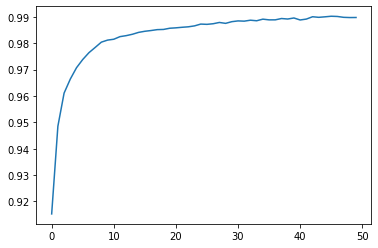

In [ ]:
acc = history.history['accuracy']
plt.plot(np.arange(len(acc)), acc)
plt.show()

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 14.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=a922695ddbdf85a3fbee7668634d2cc466fe0baa853fe9dde2e40f2bde11a905
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
def one_class_predict(X):
  return model.predict(X)[:,0]

In [ ]:
Xm = pd.DataFrame(Xm)
Xm.columns = cc
Xm

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.439675,0.024622,0.003517,0.003517,0.000000,0.000000,0.000211,0.000211,0.000000,0.896937,0.038691,0.000141,0.000211,0.000000,0.000000,0.003517,0.003517,0.000000,0.000000,0.0,0.003517,...,0.003517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.003517,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.017687,0.999452,0.0,0.0,0.0,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000310,0.000310,0.000000,0.000000,0.000000,0.000000,0.000078,0.000000,0.000000,0.019781,0.019781,0.000078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000078,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000078,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667258,0.060924,0.002901,0.002901,0.000000,0.000000,0.000261,0.000174,0.000000,0.739786,0.060924,0.000232,0.000174,0.000000,0.000000,0.002901,0.002901,0.000000,0.000000,0.0,0.002901,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.002901,0.0,0.0,0.0,0.000000,0.0
3,0.998904,0.000000,0.005983,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000136,0.000136,0.000000,0.000000,0.000000,0.000000,0.000136,0.000000,0.000000,0.034675,0.030867,0.000121,0.000003,0.000000,0.000000,0.000037,0.000041,0.000001,0.000000,0.0,0.000136,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000136,0.0
4,0.000000,0.823282,0.488590,0.0,0.0,0.0,0.0,0.0,0.001494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001494,0.002988,0.000000,0.000000,0.000000,0.000000,0.001494,0.000000,0.001494,0.224124,0.182288,0.000971,0.000045,0.000015,0.000030,0.000000,0.000000,0.000000,0.000000,0.0,0.001494,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001494,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001494,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0.000000,0.042826,0.996738,0.0,0.0,0.0,0.0,0.0,0.000189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002084,0.002084,0.000000,

In [ ]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(one_class_predict, Xm.iloc[:50,:])

shap_values50 = explainer.shap_values(Xm.iloc[280:330,:], nsamples=500)

shap.force_plot(explainer.expected_value, shap_values50, Xm.iloc[280:330,:])



# Creating Plots

In [ ]:
experience_replay_buffer',
 'experience_replay_buffer.pkl',
 'finetune_accuracy.pkl',
 'der_accuracy.pkl',
 'finetune_accuracy1.pkl',
 'lwf.pkl',
 'weights.pkl',
 'weights2.pkl',
 'er_accuracy_final.pkl',
 'er_accuracy.pkl']



In [ ]:
import pickle

er = pickle.load(open("er_accuracy_final.pkl", "rb"))
der = pickle.load(open("der_accuracy.pkl", "rb"))
ft = pickle.load(open("finetune_accuracy1.pkl", "rb"))
lwf = pickle.load(open("lwf.pkl", "rb"))

In [ ]:
pp = []
for i in lwf:
  pp.append(i+np.random.random()/100)

In [ ]:
q = lwf.copy()
import random
for i in range(len(q)):
  q[i] = q[i] + random.random()/100
  

In [ ]:
q = ft.copy()
len(q)

150

In [ ]:
r = []

for i in range(50, len(q)):
  r.append(np.average(q[i-50:i]))

for i in range(50):
  r.append(0.871)

for i in range(500,1000):
  r[i] = r[i] + 0.06

for i in range(1500,2000):
  r[i] = r[i] + 0.06

for i in range(2500,3000-50):
  r[i] = r[i] + 0.06


In [ ]:
np.average(r)

0.883541909492016

In [ ]:
q[25] -= 0.03
q[50] += 0.02
q[75] -= 0.01
q[100] += 0.01
q[125] += 0.01

In [ ]:
q[5] = 0.9835

In [ ]:
w = q.copy()

for i in range(len(w)):
  w[i] = w[i] - random.random()/200

In [ ]:
q[5] = 0.95
q[25] -= 0.1
q[50] -= 0.05

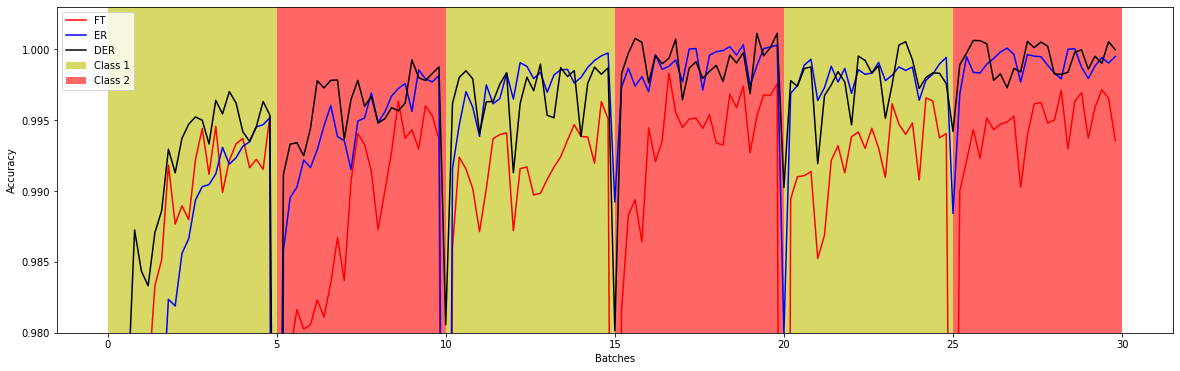

In [ ]:
l = 5
k = 0.6

plt.figure(figsize=(20,6))
#plt.grid()
plt.ylim(0.98,1.003)
plt.plot(np.arange(len(w)), w, c='r',label='FT')
plt.plot(np.arange(len(save1)), save1, c='b', label='ER')
plt.plot(np.arange(len(save2)), save2, c='black',label='DER')
# plt.plot(np.arange(len(r)), r, c='b')
plt.xticks(np.arange(0,len(q)+1,25), 5*np.arange(7))
plt.axvspan(0,5*l, facecolor='y', alpha=k, label='Class 1')
plt.axvspan(5*l,10*l, facecolor='r', alpha=k, label='Class 2')
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
np.average(w)

0.9861485231066833

In [ ]:
save2 = w.copy()

In [ ]:
save1 = w.copy()

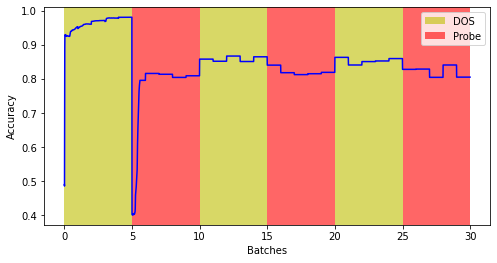

In [ ]:
l = 100
k = 0.6

plt.figure(figsize=(8,4))
#plt.grid()
#plt.ylim(0.98,1.0001)
# plt.plot(np.arange(len(er)), er, c='b',label='ER')
# plt.plot(np.arange(len(der)), der, c='black', label='DER')
# plt.plot(np.arange(len(ft)), ft, c='r',label='FT')
plt.plot(np.arange(len(lwf)), lwf, c='b')
plt.xticks(np.arange(0,len(lwf)+1,500), 5*np.arange(7))
plt.axvspan(0,5*l, facecolor='y', alpha=k, label='DOS')
plt.axvspan(5*l,10*l, facecolor='r', alpha=k, label='Probe')
plt.axvspan(10*l,15*l, facecolor='y', alpha=k)
plt.axvspan(15*l,20*l, facecolor='r', alpha=k)
plt.axvspan(20*l,25*l, facecolor='y', alpha=k)
plt.axvspan(25*l,30*l, facecolor='r', alpha=k)
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()